# Figure out how to express epsilon for a two bump core-skin profile

# Look at Sander's approach

In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

In [14]:
from scipy.interpolate import BPoly
from scipy.integrate import quad
import sys
sys.path.append('../..')
sys.path.append('../../scipy_mod')
import equil_solver as es
reload(es)

import fitpack
from fitpack import splev

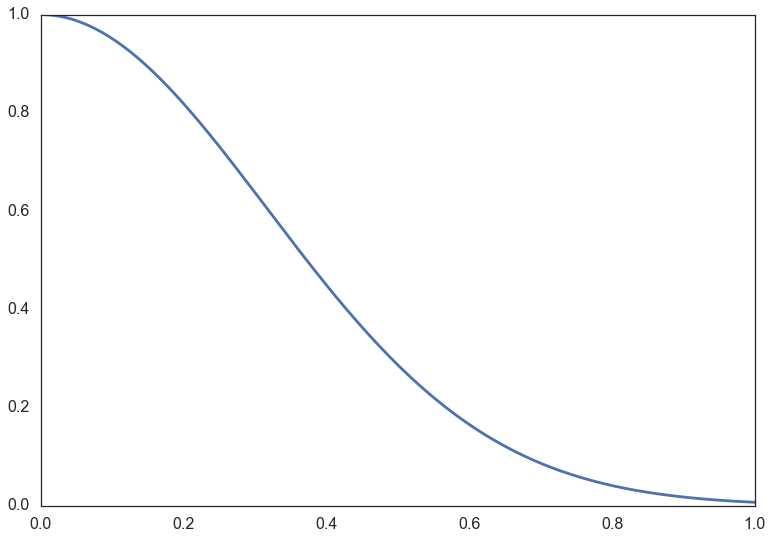

In [15]:
r = np.linspace(0, 1, 200)
j_z = np.exp(-5*r**2)
plt.plot(r, j_z)

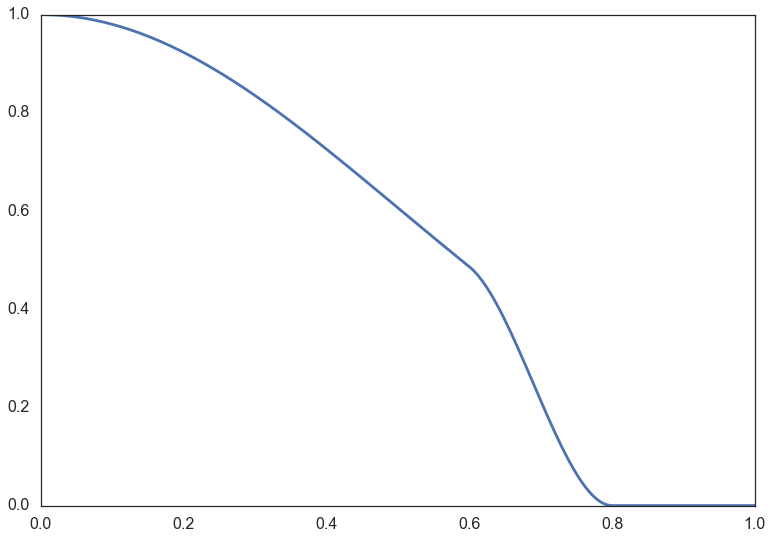

In [16]:
r = np.linspace(0, 1, 200)
core = np.exp(-2*r**2)
skin_peak = 0
skin = BPoly.from_derivatives([0.6, 0.8, 1.0], [[np.exp(-2*0.6**2), -4*0.6*np.exp(-2*0.6**2)], [skin_peak, 0.], [0.,0.]])
j_z = core
indexes = np.where(r >= 0.6)
j_z[indexes] = skin(r[indexes])
plt.plot(r, j_z)

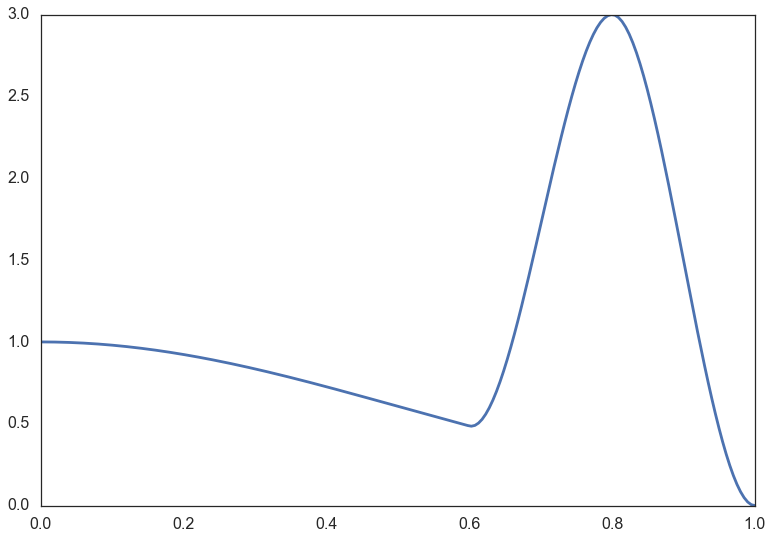

In [17]:
r = np.linspace(0, 1, 200)
core = np.exp(-2*r**2)
skin_peak = 3
skin = BPoly.from_derivatives([0.6, 0.8, 1.0], [[np.exp(-2*0.6**2), -4*0.6*np.exp(-2*0.6**2)], [skin_peak, 0.], [0.,0.]]                                                                               )
j_z = core
indexes = np.where(r >= 0.6)
j_z[indexes] = skin(r[indexes])
plt.plot(r, j_z)

# Find relationship between peak skin current and epsilon

In [18]:
def skin_current_integrand(r, skin_peak):
    skin = BPoly.from_derivatives([0.6, 0.8, 1.0], [[np.exp(-2*0.6**2), -4*0.6*np.exp(-2*0.6**2)], [skin_peak, 0.], [0.,0.]])
    return skin(r)*r

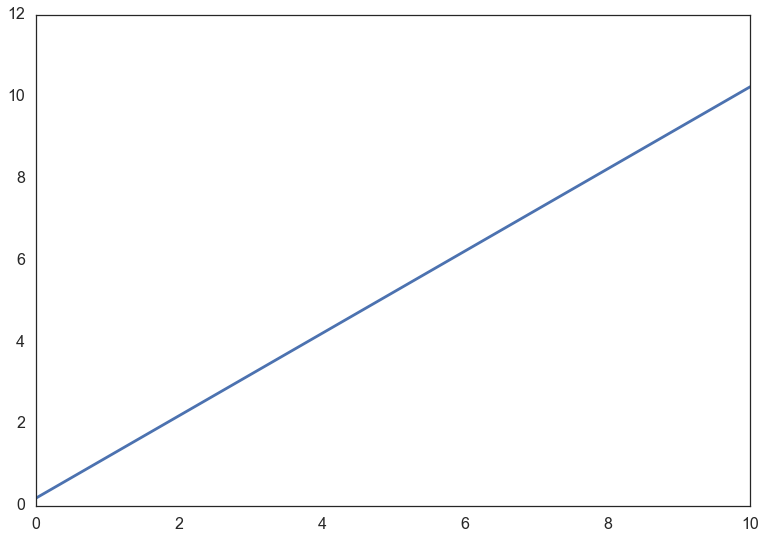

In [19]:
skin_peaks = np.linspace(0, 10, 200)
integrals = []
for skin_peak in skin_peaks:
    def skin_current_integrand(r):
        skin = BPoly.from_derivatives([0.6, 0.8, 1.0], [[np.exp(-2*0.6**2), -4*0.6*np.exp(-2*0.6**2)], [skin_peak, 0.], [0.,0.]])
        return skin(r)*r
    integrals.append(quad(skin_current_integrand, 0.6, 1.)[0]*2*np.pi)
    
plt.plot(skin_peaks, integrals)

In [20]:
from scipy.stats import linregress
linregress(skin_peaks, integrals)

In [21]:
def skin_current(skin_peak):
    return (1.0053096491487337 * skin_peak + 0.18521395596186707)

In [22]:
def core_integrand(r):
    return np.exp(-2*r**2)*r

In [23]:
core_current = quad(core_integrand, 0, 0.6)[0]*2*np.pi

In [24]:
print core_current

0.806207671074


In [25]:
def epsilon(skin_peak):
    return core_current / (core_current + skin_current(skin_peak))

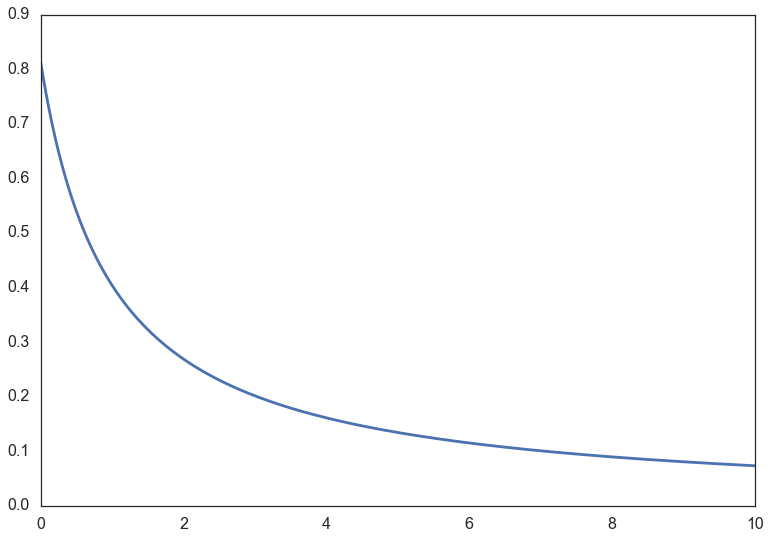

In [26]:
skin_peaks = np.linspace(0, 10, 200)
plt.plot(skin_peaks, epsilon(skin_peaks))

In [27]:
def peak(epsilon, i_core=0.806207671074, slope=1.0053096491487337, offset=0.18521395596186707):
    return (i_core/epsilon - i_core - offset) / slope

# I added a diffuse skin core current profile to equil_solver.
# Let's plot the profiles, check that their epsilon is consistent and check their suydam stability.

In [28]:
test_profile = es.UnitlessExponentialDecaySkin(k_bar=1., 
                                               epsilon=1, 
                                               lambda_bar=0.5)

In [29]:
splines = test_profile.get_splines()

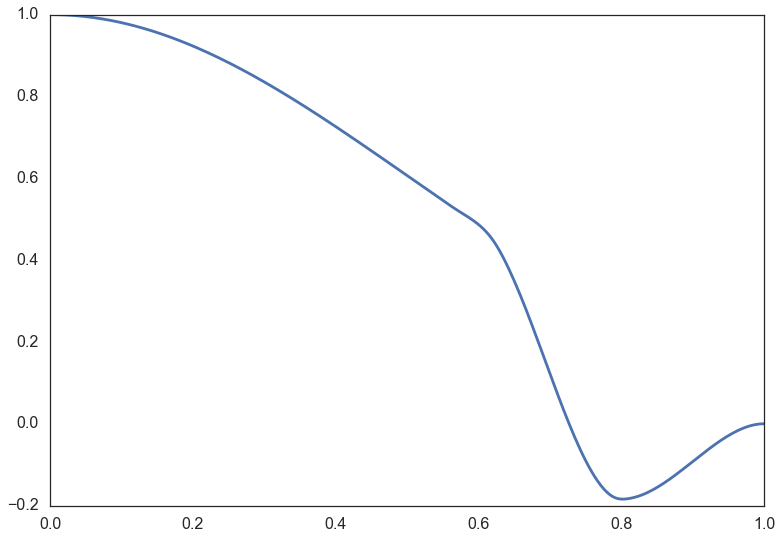

In [30]:
x = np.linspace(0, 1, 250)
plt.plot(x, splines['j_z'](x))

# Double check that epsilon is correct

In [31]:
def j_z_integrand(r):
    return splines['j_z'](r)*r*2.*np.pi

In [32]:
quad(j_z_integrand, 0, 0.6)[0] / quad(j_z_integrand, 0., 1.)[0]

# Setup Suydam criterion

In [33]:
sys.path.append('../..')
import singularity_frobenius as sing_frob

In [34]:
r = np.linspace(0, 1., 250)
b_z = splines['b_z'](r)
b_z_prime = splines['b_z_prime'](r)
b_theta = splines['b_theta'](r)
b_theta_prime = splines['b_theta_prime'](r)
p_prime = splines['p_prime'](r)
beta_0 = test_profile.beta_0()

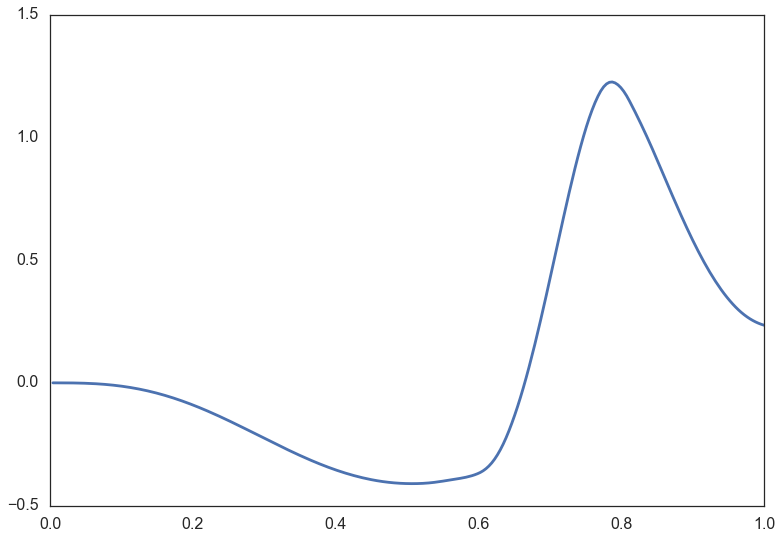

In [35]:
alpha = sing_frob.alpha_func(r, b_z, b_z_prime, b_theta, b_theta_prime)
beta = sing_frob.beta_func(b_z, b_theta, p_prime, beta_0)
suydam_condition = alpha + 4.*beta
plt.plot(r, suydam_condition)

In [36]:
def suydam_condition(r, k_bar, epsilon, lambda_bar):
    profile = es.UnitlessExponentialDecaySkin(k_bar=k_bar, 
                                              epsilon=epsilon, 
                                              lambda_bar=lambda_bar)
    splines = profile.get_splines()
    b_z = splines['b_z'](r)
    b_z_prime = splines['b_z_prime'](r)
    b_theta = splines['b_theta'](r)
    b_theta_prime = splines['b_theta_prime'](r)
    p_prime = splines['p_prime'](r)
    beta_0 = test_profile.beta_0()
    
    alpha = sing_frob.alpha_func(r, b_z, b_z_prime, b_theta, b_theta_prime)
    beta = sing_frob.beta_func(b_z, b_theta, p_prime, beta_0)
    condition = alpha + 4.*beta
    
    return condition

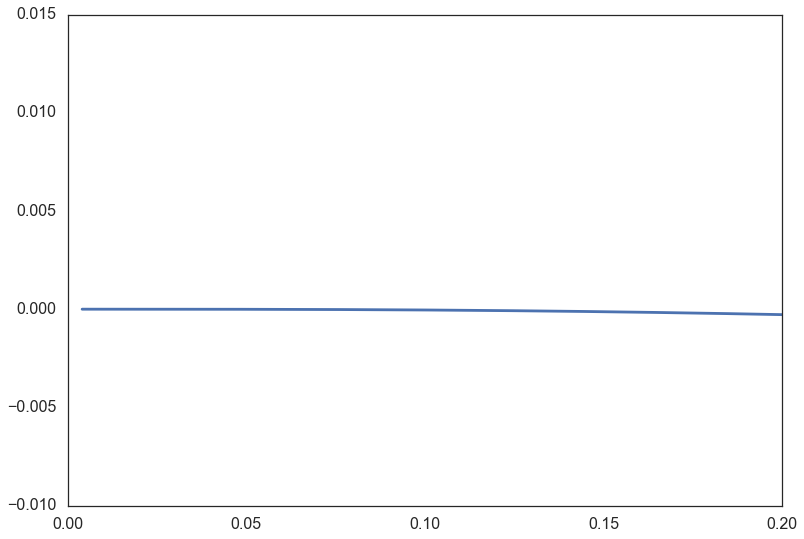

In [38]:
r = np.linspace(0, 1., 250)
condition = suydam_condition(r, 0.1, 0.4, 0.1)
plt.plot(r, condition)
plt.xlim(0, 0.2)

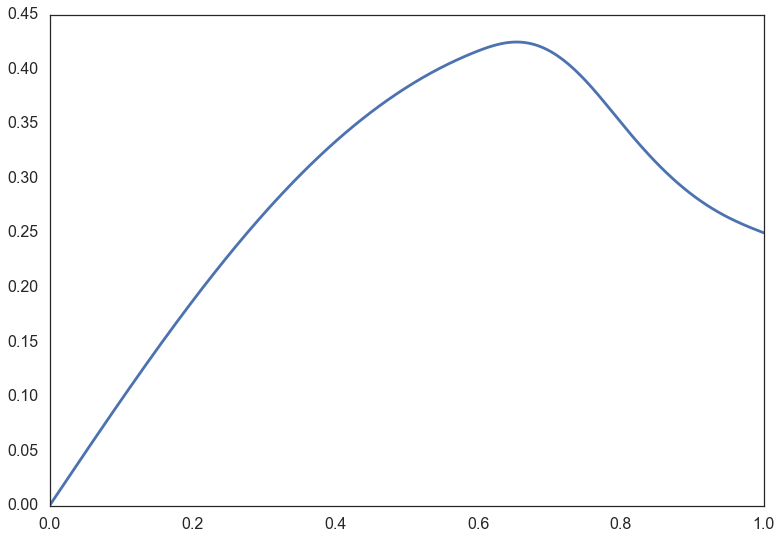

In [49]:
plt.plot(r, splines['b_theta'](r))

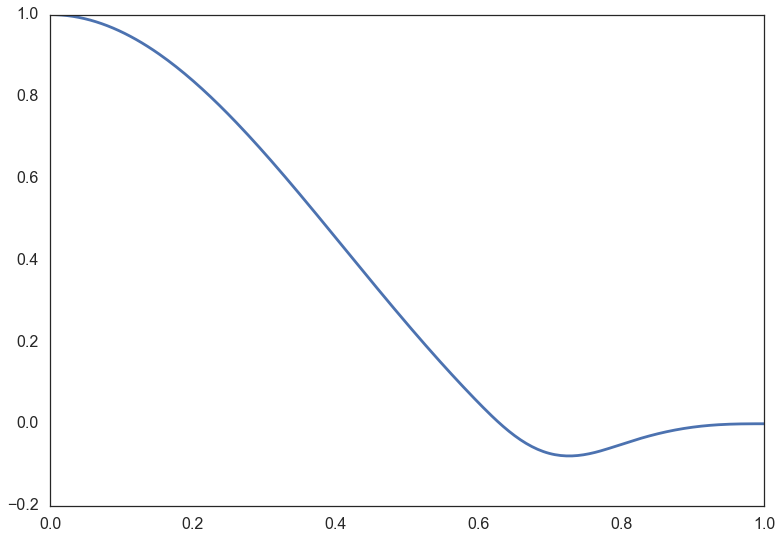

In [41]:
plt.plot(r, splines['pressure'](r))

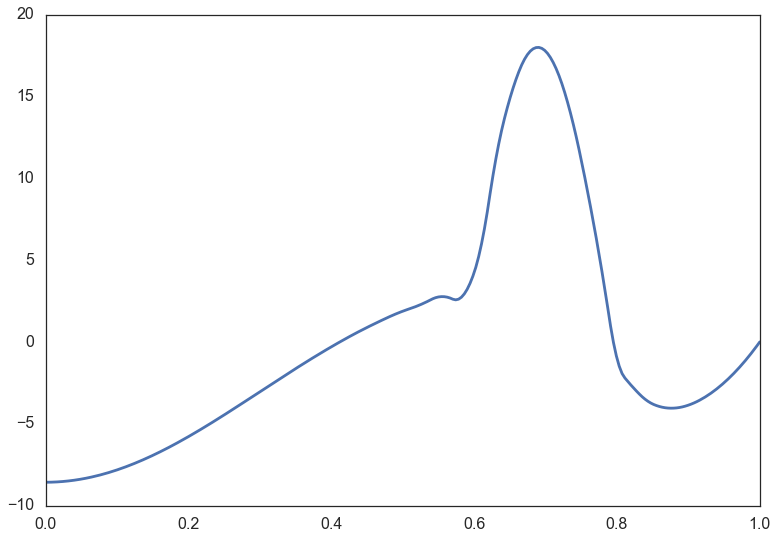

In [48]:
plt.plot(r, splines['p_prime'].derivative()(r))

# Plot Suydam criterion for varying $\epsilon$, $\bar{\lambda}$, $\bar{k}$

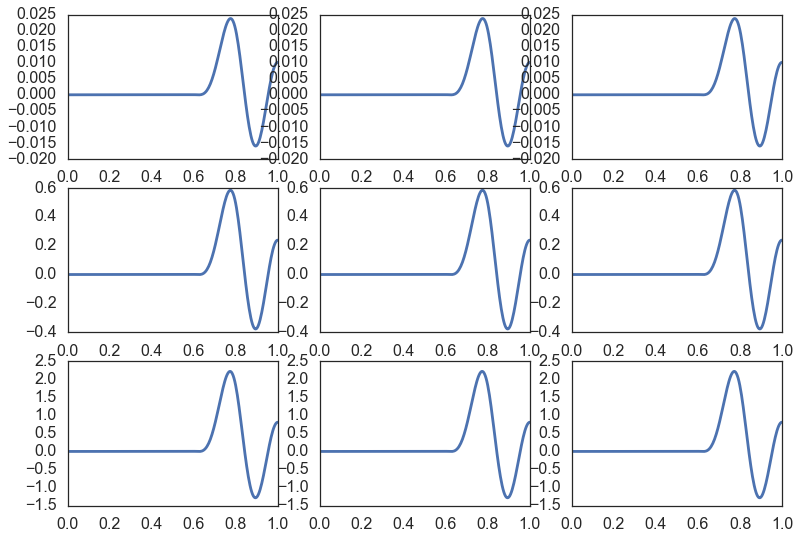

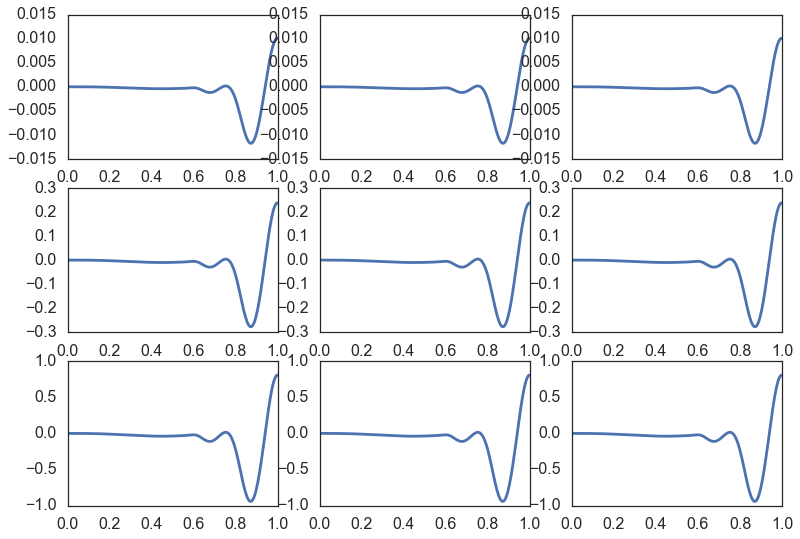

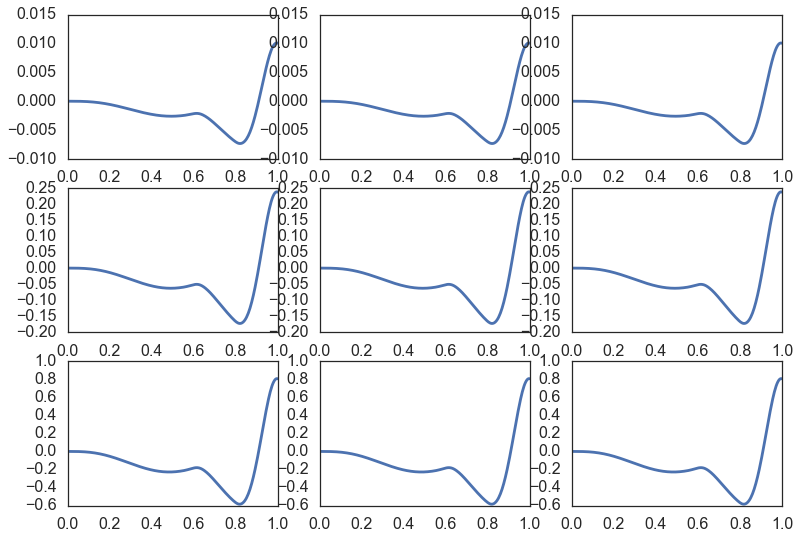

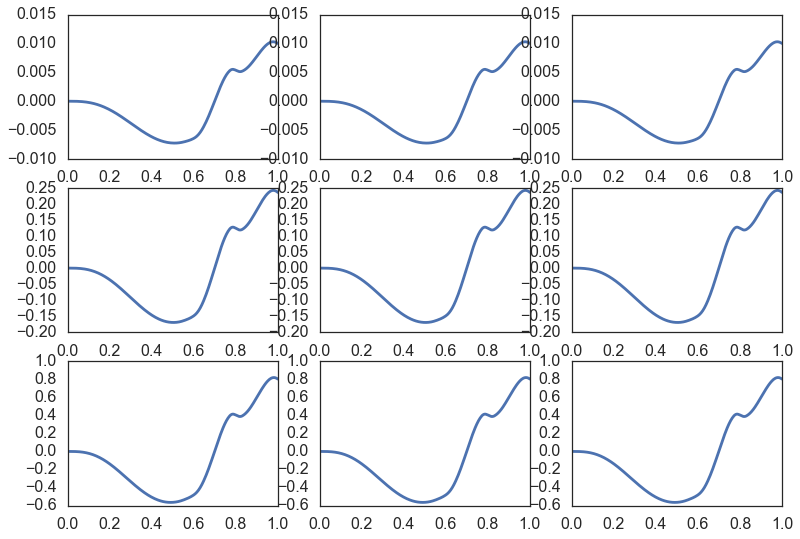

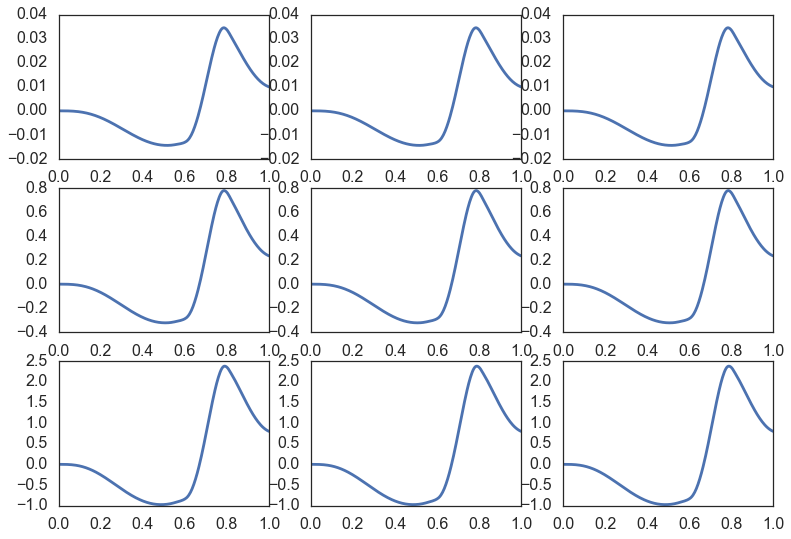

In [98]:
for epsilon in [0.1, 0.3, 0.5, 0.7, 0.9]:
    fig, axes = plt.subplots(3, 3)
    axes = axes.ravel()
    counter = 0
    for lambda_bar in [0.1, 0.5, 1.0]:
        for k_bar in [0.1, 0.5, 1.0]:
            r = np.linspace(0, 1., 250)
            condition = suydam_condition(r, k_bar, epsilon, lambda_bar)
            axes[counter].plot(r, condition)
            counter += 1

# Look at suydam criterion for constant $Bz$

# $ − \frac{\partial p}{\partial r} < \frac{B_z (1−2r \frac{\partial B_θ}{\partial r}+r^2 (\frac{\partial B_θ}{\partial r})^2)}{(8\mu_0 r)} $

In [1]:
import sympy as sp
sp.init_printing()

In [8]:
(r, mu_0) = sp.symbols(r'r \mu_0')
p, b_z, b_theta = sp.symbols(r'p B_z B_\theta', cls=sp.Function)

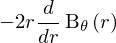

In [10]:
negative_term = -2*r*sp.diff(b_theta(r), r)
negative_term

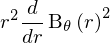

In [11]:
positive_term = r**2*(sp.diff(b_theta(r), r))**2
positive_term

In [ ]:
def negativre_term()